# Inter-laboratory comparison of 3D running kinematics

Reginaldo K Fukuchi 

This NB does the following:
* Descriptive and inferential stats of demographics
* SPM and RMSE analyses between centres
* Create ensemble time series curves for the groups
* Batch process calculation of time normalized 3D kinematics of pelvis and lower-extremity joints

In [1]:
# Prepare environment
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pingouin as pg

%matplotlib inline

import sys
sys.path.insert(1, r'../functions')

pd.set_option("display.precision", 2)

## Supporting stats functions

In [2]:
def ttest(df, var, factor, levels=None, alpha=0.05):
    """t-test statistcs for dataframe columns using the pingouin library.
    """
    stats = pd.DataFrame()
    if levels is None:
        levels = df[factor].unique()
    if len(levels) != 2:
        raise Exception('Incorrect number of levels: {}'.format(len(levels)))
    for v in var:
        x = df[df[factor] == levels[0]][v]
        y = df[df[factor] == levels[1]][v]
        stat = pg.ttest(x, y)
        stat.index = [v]
        stats = pd.concat([stats, stat], axis=0)
    stats.drop(columns=['BF10', 'power'], inplace=True)
    stats.index.name = '{}-{}'.format(*levels)
    display(stats.style.format({'p-val': '{:.3f}'}).apply(sig_red, subset='p-val', axis=1))
    return stats

def normality(df):
    """Get the p-val of the normality test using the pingouin library.
    """
    return pg.normality(df)['pval']

def sig_red(col, alpha=0.05):
    """Returns string 'color: red' for `col` < `alpha`, black otherwise.
    """
    is_sig = col < alpha
    return ['color: red' if x else 'color: black' for x in is_sig]

def describe(df, by, var=['count', 'mean', 'std', 'min', 'max', normality]):
    """Descriptive statistics for dataframe columns.
    """
    x = df.groupby(by).agg(var).stack().transpose()
    display(x.style.apply(sig_red,
                          subset=[col for col in x.columns if col[1] == 'normality']))    
    return x

In [3]:
# File directories 
dir_data = r'../data' 

## Descriptive stats
### Age, height and mass

In [4]:
info_both = pd.read_csv(os.path.join(dir_data, 'info_both.csv'), 
                        usecols = ['sub_id', 'filename', 'speed', 'Age', 'Height', 
                                   'Mass', 'group'])

In [5]:
var = ['group', 'Age', 'Height', 'Mass']
describe(info_both[var], 'group', var=['count', 'mean', 'std', normality]);

In [6]:
stats = ttest(info_both, var[1:], 'group', levels=['RBDS', 'RIC'])

,T,dof,alternative,p-val,CI95%,cohen-d
RBDS-RIC,,,,,,
Age,0.440598,44,two-sided,0.662,[-2.49 3.88],0.129925
Height,-0.276058,44,two-sided,0.784,[-3.54 2.68],0.081405
Mass,-3.694270,44,two-sided,0.001,[-12.91 -3.79],1.089381


## Ensemble time-series, SPM and RMSE
* Create ensemble time-series curves of hip, knee and ankle joint throughout the gait cycle for each group (RBDS and RIC). 
* Perform a time-series analysis using [Statistical Parametric Mapping](http://www.scholarpedia.org/article/Statistical_parametric_mapping)
* Calculate the Root mean square error between groups to estimate the differences

In [7]:
#L_ang_RBDSall = np.load(os.path.join(dir_data, 'L_angs_RBDSall.npy'))
R_ang_RBDSall = np.load(os.path.join(dir_data, 'R_angs_RBDSall.npy'))
#L_ang_RICall  = np.load(os.path.join(dir_data, 'L_angs_RICall.npy'))
R_ang_RICall  = np.load(os.path.join(dir_data, 'R_angs_RICall.npy'))

In [8]:
R_ang_RBDS = np.empty(shape=(101,15,R_ang_RBDSall.shape[3])) * np.NaN
for s in range(R_ang_RBDSall.shape[3]):
    angs_temp_R = R_ang_RBDSall[:,:,:,s]
    R_angs= angs_temp_R[:,~np.isnan(angs_temp_R).all(axis=0)].reshape((101,15,-1))
    R_ang_RBDS[:,:,s] = np.median(R_angs, axis=2)

In [9]:
R_ang_RIC = np.empty(shape=(101,15,R_ang_RICall.shape[3])) * np.NaN
for s in range(R_ang_RICall.shape[3]):
    angs_temp_R = R_ang_RICall[:,:,:,s]
    R_angs= angs_temp_R[:,~np.isnan(angs_temp_R).all(axis=0)].reshape((101,15,-1))
    R_ang_RIC[:,:,s] = np.median(R_angs, axis=2)

In [10]:
# Consider only hip, knee and ankle
R_ang_RBDS, R_ang_RIC = R_ang_RBDS[:,6:,:], R_ang_RIC[:,6:,:]

## RMSE

In [11]:
#joints = ['pelvis','foot','hip','knee','ankle']
joints = ['hip','knee','ankle']
axes = ['X','Y','Z']

In [12]:
RMSEme = np.sqrt(np.square(np.subtract(R_ang_RBDS,R_ang_RIC)).mean(axis=0)).mean(axis=1)
RMSEsd = np.sqrt(np.square(np.subtract(R_ang_RBDS,R_ang_RIC)).mean(axis=0)).std(axis=1)

In [13]:
# Create lists for the plot
ang_xyz_lbls = [i+'_'+j for i in joints for j in axes]
x_pos = np.arange(len(ang_xyz_lbls))

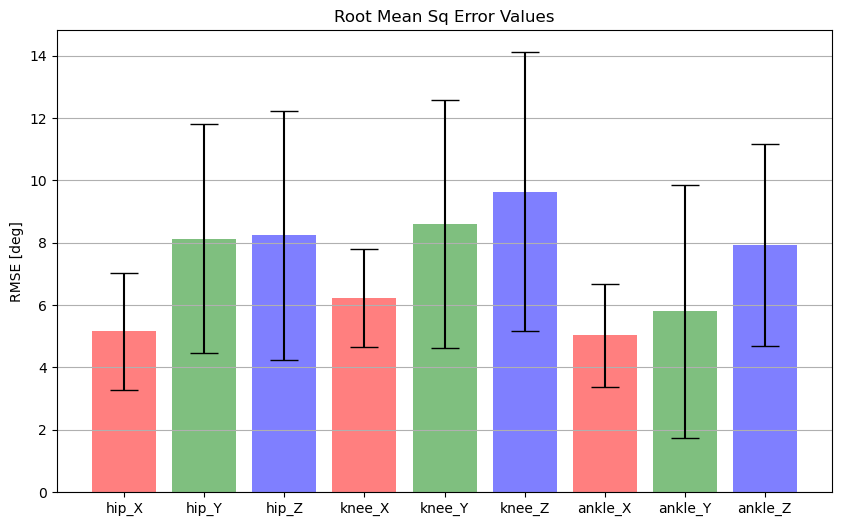

In [14]:
# Build the plot
fig, ax = plt.subplots(1,figsize=(10,6))
ax.bar(x_pos, RMSEme, yerr=RMSEsd, align='center', alpha=0.5, ecolor='black', 
       capsize=10, color=['r','g','b','r','g','b','r','g','b'])
ax.set_ylabel('RMSE [deg]')
ax.set_xticks(x_pos)
ax.set_xticklabels(ang_xyz_lbls)
ax.set_title('Root Mean Sq Error Values')
ax.yaxis.grid(True)
plt.show()

In [15]:
# Save the figure and show
# fig.savefig(os.path.join(dir_data, 'RMSe.png'), bbox_inches='tight')

In [16]:
# Right side
R_ang_RBDSme, R_ang_RBDSsd= np.mean(R_ang_RBDS, axis=2), np.std(R_ang_RBDS, axis=2)
R_ang_RICme, R_ang_RICsd  = np.mean(R_ang_RIC, axis=2), np.std(R_ang_RIC, axis=2)
# Left side
# L_ang_RBDSme, L_ang_RBDSsd= np.mean(L_ang_RBDS, axis=2), np.std(L_ang_RBDS, axis=2)
# L_ang_RICme, L_ang_RICsd  = np.mean(L_ang_RIC, axis=2), np.std(L_ang_RIC, axis=2)

## Plot angles

In [17]:
import spm1d

In [18]:
tn = np.linspace(0,100,101)

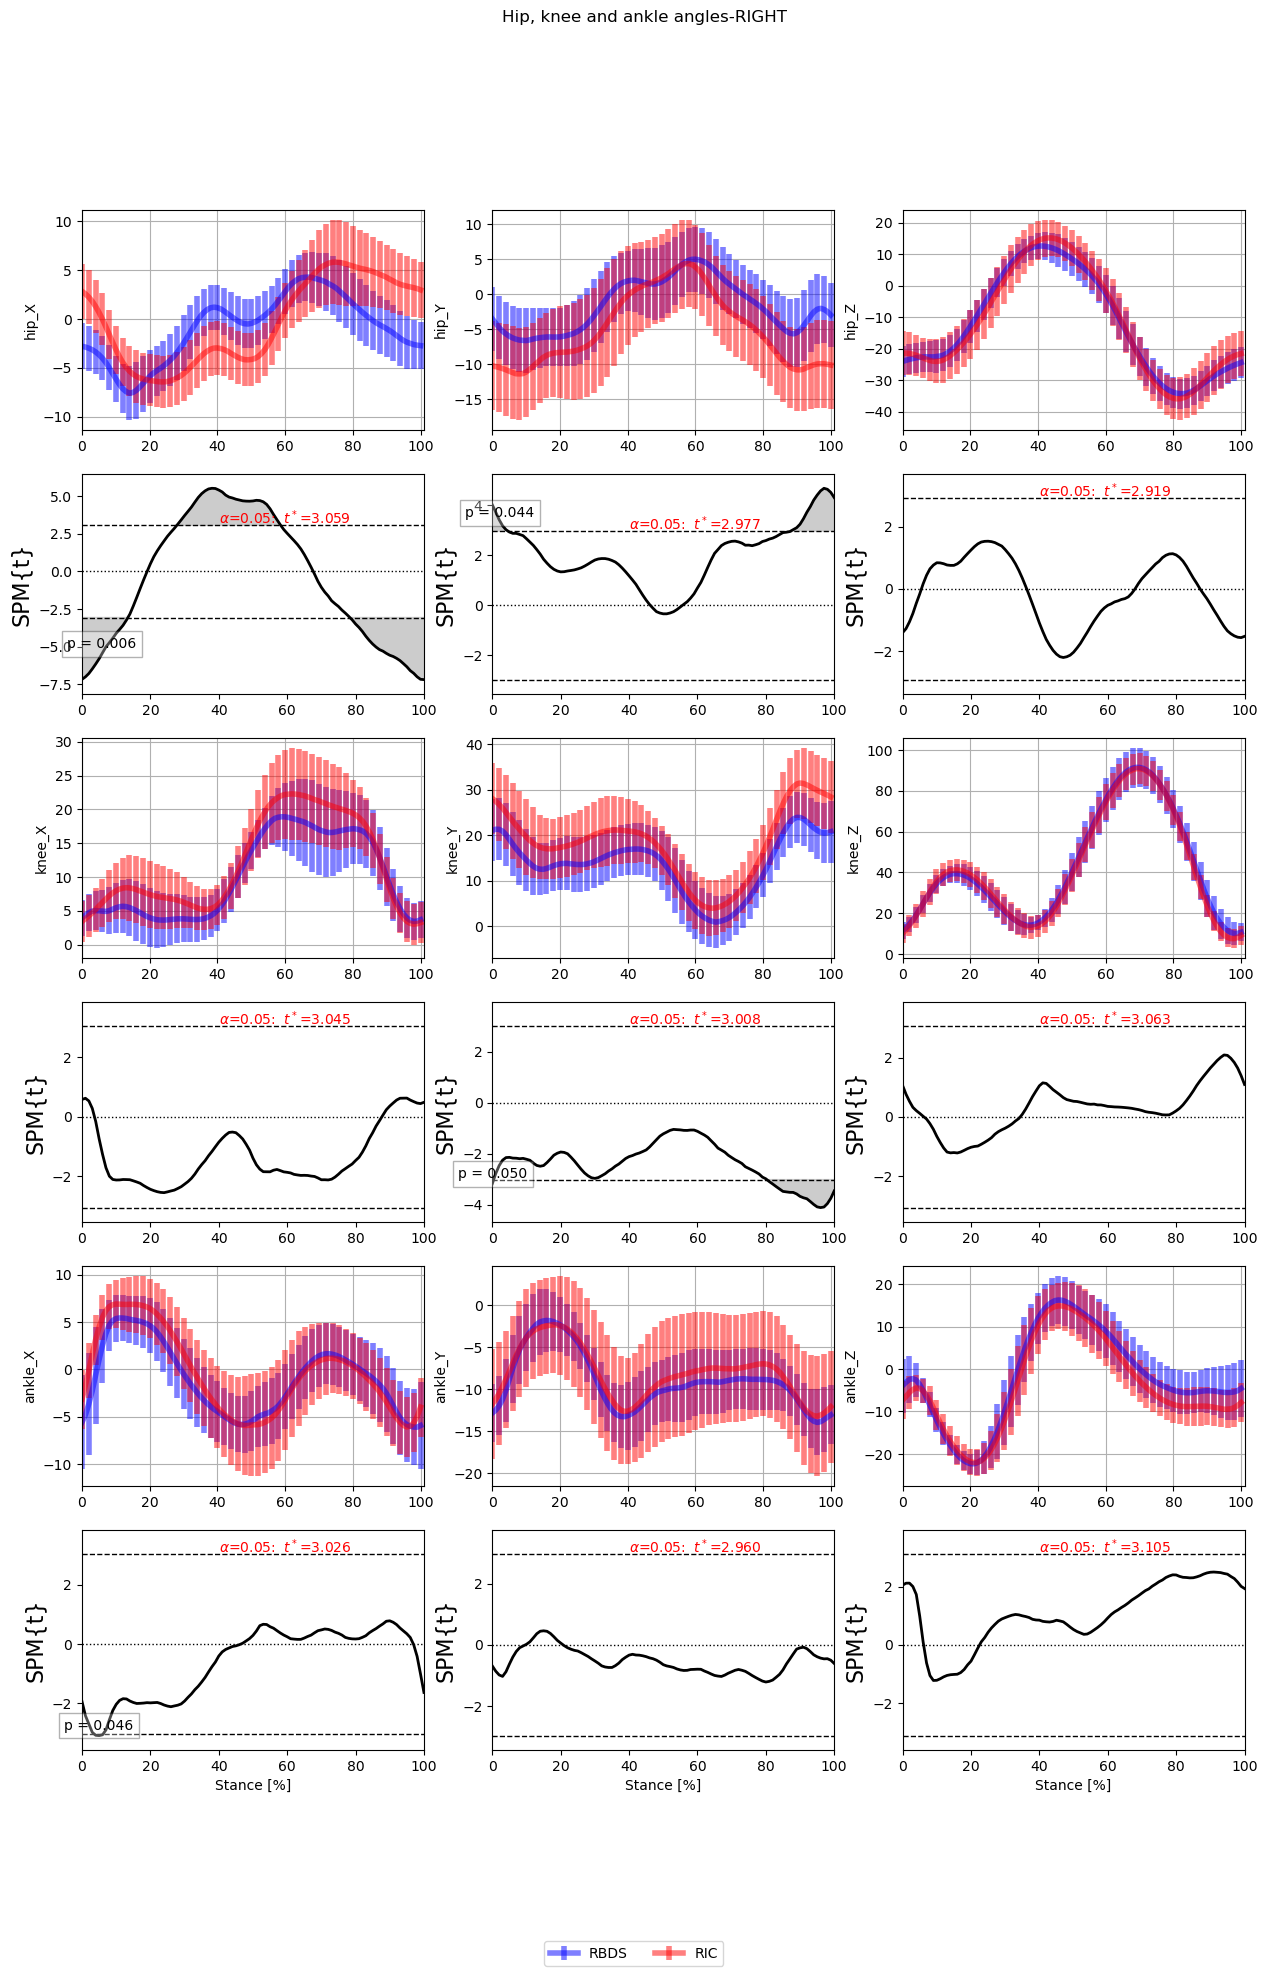

In [19]:
fig, axs = plt.subplots(6,3, figsize=(15,20))
fig.suptitle('Hip, knee and ankle angles-RIGHT')
for j, joint in enumerate(joints):
    for xyz, eixo in enumerate(axes):
        #axs[j,xyz].plot(tn,angsR3[:,3*j+xyz,:])
        axs[2*j,xyz].errorbar(tn,R_ang_RBDSme[:,3*j+xyz],R_ang_RBDSsd[:,3*j+xyz],
                           color = [0, 0, 1, 0.5], capsize=0, errorevery=2, lw=4)
        axs[2*j,xyz].errorbar(tn,R_ang_RICme[:,3*j+xyz],R_ang_RICsd[:,3*j+xyz],
                           color = [1, 0, 0, 0.5], capsize=0, errorevery=2, lw=4)
        axs[2*j,xyz].set_ylabel(joint+'_'+eixo)
        axs[2*j,xyz].set_xlim([0,101])
        axs[2*j,xyz].grid('on')
        
        # SPM calculation
        Ymen = R_ang_RBDS[:, 3*j+xyz, :]
        Yfem = R_ang_RIC[:, 3*j+xyz, :]
        t_j  = spm1d.stats.ttest2(Ymen.T, Yfem.T, 
                            equal_var=False)
        ti_j = t_j.inference(alpha=0.05, two_tailed=True, interp=True)
        ti_j.plot(ax=axs[2*j+1,xyz])
        ti_j.plot_threshold_label(ax=axs[2*j+1,xyz])
        ti_j.plot_p_values(ax=axs[2*j+1,xyz], size=10, offsets=[(0,0.3)])
        
        if j==2:
            axs[5,xyz].set_xlabel('Stance [%]')
fig.legend(['RBDS','RIC'], loc='lower center', ncol=2)
plt.show()

In [20]:
#fig.savefig(os.path.join(dir_data, 'SPM_compare_plot_.png'), bbox_inches='tight')

## Batch process datasets
Run the cells below in case one wants to re-calculate the time normalized angles and store them in arrays to be saved.

In [ ]:
# Support functions
import parse_gait_kinematics as parse_gait
from gait_steps import gait_steps
from gait3d_angles import gait3d_angles
from tnorma import tnorma

## Import data

In [ ]:
method = 'RBDS'

In [ ]:
if method=='RIC':
    RIC_df=info_both[info_both['group']=='RIC']
    # RIC list of subjects and files
    RIC_dir = r'C:\Users\Reginaldo\OneDrive - University of Calgary\data\Figshare_SciData\new_unzip'
    sub_ids = RIC_df['sub_id'].tolist()
    fn_RIC  = RIC_df['filename'].tolist()    
else:# RBDS
    RBDS_df=info_both[info_both['group']=='RBDS']
    RBDS_dir = r'C:\Users\Reginaldo\Documents\data\CNPq\RBDS_v2\Figshare'
    sub_ids  = [f[:-10] for f in RBDS_df['filename'].tolist()]

In [ ]:
sub_ids = sub_ids[:2]

RBDS too about 8 minutes [08:07<00:00, 18.19s/it]

In [ ]:
# Import JSON files
angsR2  = np.empty(shape=(101,15,len(sub_ids)))*np.NaN
angsL2  = np.empty(shape=(101,15,len(sub_ids)))*np.NaN
angsRall= np.empty(shape=(101,15,100,len(sub_ids)))*np.NaN
angsLall= np.empty(shape=(101,15,100,len(sub_ids)))*np.NaN
for s, subject in tqdm(enumerate(sub_ids), desc='Loading...', leave=True):
    if method=='RIC':
        # Running Injury Clinic data set
        fn_json=os.path.join(RIC_dir, str(sub_ids[s]), fn_RIC[s])
        neutral, joints, gait, hz = parse_gait.parse_RIC(fn_json)
    else:
        fn_static = os.path.join(RBDS_dir,subject+'static.c3d')
        fn_gait = os.path.join(RBDS_dir,subject+'runT25.c3d')
        neutral, joints, gait, hz = parse_gait.parse_RBDS(fn_static, fn_gait, filt=True)

    # Calculate joint angles
    virt_mkrs, angles = gait3d_angles(neutral, joints, gait)

    # Convert dict in arrays
    L_ankle_ang, R_ankle_ang = angles['L_ankle_ang'], angles['R_ankle_ang']
    L_knee_ang, R_knee_ang = angles['L_knee_ang'], angles['R_knee_ang']
    L_hip_ang, R_hip_ang = angles['L_hip_ang'], angles['R_hip_ang']
    L_foot_ang, R_foot_ang = angles['L_foot_ang'], angles['R_foot_ang']
    pelvis_ang = angles['pelvis_ang']

    # Convert angles in degrees
    L_ankle_ang, R_ankle_ang = L_ankle_ang * (180/np.pi), R_ankle_ang * (180/np.pi)
    L_knee_ang, R_knee_ang = L_knee_ang * (180/np.pi), R_knee_ang * (180/np.pi)
    L_hip_ang, R_hip_ang = L_hip_ang * (180/np.pi), R_hip_ang * (180/np.pi)
    L_foot_ang, R_foot_ang = L_foot_ang * (180/np.pi), R_foot_ang * (180/np.pi)
    pelvis_ang = pelvis_ang * (180/np.pi)

    # Structure the data to be input into gait_steps
    joints_lbls = ['pelvis','L_foot','R_foot','L_hip','R_hip','L_knee','R_knee',
                   'L_ankle','R_ankle']
    xyz = list('XYZ')*len(joints_lbls)
    joints_lbls = [ele for ele in joints_lbls for i in range(3)]
    joints_lbls = [joints_lbls[i]+'_'+xyz[i] for i in range(len(xyz))]

    # Create a pandas df with angles
    angs = np.hstack([pelvis_ang, L_foot_ang, R_foot_ang, 
                      L_hip_ang, R_hip_ang, L_knee_ang, R_knee_ang, 
                      L_ankle_ang, R_ankle_ang])
    angles = pd.DataFrame(data=angs, columns=joints_lbls)

    # Detect gait events using gait_steps.py
    L_TD_RIC, L_TO_RIC, R_TD_RIC, R_TO_RIC, eventsflag_RIC, label_RIC = gait_steps(neutral, gait, angles, hz)
    RTD_RIC, RTO_RIC = R_TD_RIC.astype(int).tolist(), R_TO_RIC.astype(int).tolist()
    LTD_RIC, LTO_RIC = L_TD_RIC.astype(int).tolist(), L_TO_RIC.astype(int).tolist()

    # Right side 
    anglesR = angles.loc[:, angles.columns.str.contains('|'.join(['R_', 'pelvis']))]
    angsR = np.empty(shape=(101,anglesR.shape[1],len(RTD_RIC)-1))
    for iR in range(len(RTD_RIC)-1):
        angsR[:,:,iR], tn, indie = tnorma(anglesR.values[RTD_RIC[iR]:RTD_RIC[iR+1],:], 
                                          k=1, smooth=0, mask=None, show=False)

    # Left side
    anglesL = angles.loc[:, angles.columns.str.contains('|'.join(['L_', 'pelvis']))]
    angsL = np.empty(shape=(101,anglesL.shape[1],len(LTD_RIC)-1))
    for iL in range(len(LTD_RIC)-1):
        angsL[:,:,iL], tn, indie = tnorma(anglesL.values[LTD_RIC[iL]:LTD_RIC[iL+1],:], 
                                          k=1, smooth=0, mask=None, show=False)
    # Store avg of each subject
    angsR2[:, :, s] = np.mean(angsR, axis=2)
    angsL2[:, :, s] = np.mean(angsL, axis=2)
    
    # Store all gait cycles
    angsRall[:,:,:len(RTD_RIC)-1,s] = angsR
    angsLall[:,:,:len(LTD_RIC)-1,s] = angsL
    #print(str(sub_ids[s])+ ' and ' + fn_RIC[s])

In [ ]:
# np.save(os.path.join(dir_data, 'R_angs_'+method+'all.npy'), angsRall)
# np.save(os.path.join(dir_data, 'L_angs_'+method+'all.npy'), angsLall)
# np.save(os.path.join(dir_data, 'R_angs_'+method+'.npy'), angsR2)
# np.save(os.path.join(dir_data, 'L_angs_'+method+'.npy'), angsL2)